<a href="https://colab.research.google.com/github/SanjayDwarapureddy/Converter/blob/main/Food_recognition_system_using_CNN%2C_MobileNetV2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("l33tc0d3r/indian-food-classification")

print("Path to dataset files:", path)

100%|██████████| 1.48G/1.48G [00:14<00:00, 110MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/l33tc0d3r/indian-food-classification/versions/1


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.preprocessing import image

In [4]:
image_dir = Path('/root/.cache/kagglehub/datasets/l33tc0d3r/indian-food-classification/versions/1')
#The path to the image directory was incorrect.
#Changing it to the correct path solves the issue
#The glob function was looking for files in the wrong directory
#It should be looking for files in /kaggle/input/indian-food-classification/Food Classification
#The incorrect path is ../input/indian-food-classification/Food Classification

**Creating file dataframe**

In [5]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
#using glob to target particular image files

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
#separating the class names from the file paths and saving in labels

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(130, random_state=1))
#concatenate category samples
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)



In [6]:
image_df['Label'].value_counts()

,count
Label,
fried_rice,130
chole_bhature,130
jalebi,130
burger,130
dal_makhani,130
paani_puri,130
pizza,130
kadai_paneer,130
masala_dosa,130


**train-test split**

In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
#70% training 30% test
#since we are shuffling, random state = 1

**creating generators**

In [8]:
#limited memory so we train in batches to recycle memory
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

We are using a pre-trained model mobilenetV2 from tensorflow which is a CNN architecture.
https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c


In [9]:
#this train_images will be passed into our fit function
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
#default image size for mobilenetV2 is 224x224
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
#shuffle after each epoch
    seed=42,
    subset='training'
#only available if validation_split is used to specify whether to use validation subset 0.2 or training subset

)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1456 validated image filenames belonging to 20 classes.
Found 363 validated image filenames belonging to 20 classes.
Found 781 validated image filenames belonging to 20 classes.


**modeling**

In [10]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
#we dont wanna keep the classification layer of the og dataset on which the model is pretrained we just want our dataset's classification layer
#originally trained on imagenet  dataset 1000 classes
    weights='imagenet',
#to keep the same weights
    pooling='avg'
#output is 1d now
)

pretrained_model.trainable = False
#to not change the original imagenet weights
#We are transfering learning of the model so we keep it as it is
#This model is good for feature extraction
#Use the same model, remove the top layer, use your own top layer i.e. classes, dataset

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
#128 neurons
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(20, activation='softmax')(x)
#classification layer
model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,441,044 (9.31 MB)

 Trainable params: 183,060 (715.08 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


**training**

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    #as classes are encoded as vectors by the generator so we use categorical_crossentropy
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=10,
    #INCREASE NO. OF EPOCHS TO INCREASE ACCURACY (77.46% ACCURACY ACHIEVED ON 100 EPOCHS)
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='validation_loss',
            patience=3,
            #when validation loss stops improving for 3 consecutive epochs training will be stopped and best epochs weights are restored
            restore_best_weights=True,
            mode='min' # Add this line to specify the mode
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.2797 - loss: 2.5596 - val_accuracy: 0.6474 - val_loss: 1.2594
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `validation_loss` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7410 - loss: 0.9394 - val_accuracy: 0.7383 - val_loss: 0.9001
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8618 - loss: 0.5353 - val_accuracy: 0.7603 - val_loss: 0.8267
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9014 - loss: 0.3543 - val_accuracy: 0.7741 - val_loss: 0.7297
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9666 - loss: 0.1846 - val_accuracy: 0.7466 - val_loss: 0.8047
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9870 - loss: 0.1136 - val_accuracy: 0.7879 - val_loss: 0.7387
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9973 - loss: 0.0600 - val_accuracy: 0.7796 - val_loss: 0.7473
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9993 - loss: 0.0397 - val_accuracy: 0.7769 - val_loss: 0.7445
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.7906 - val_loss: 0.

**results**

In [13]:
results = model.evaluate(test_images, verbose=0)
#gives loss and accuracy for test set
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 78.23%


**predictions**

In [14]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step


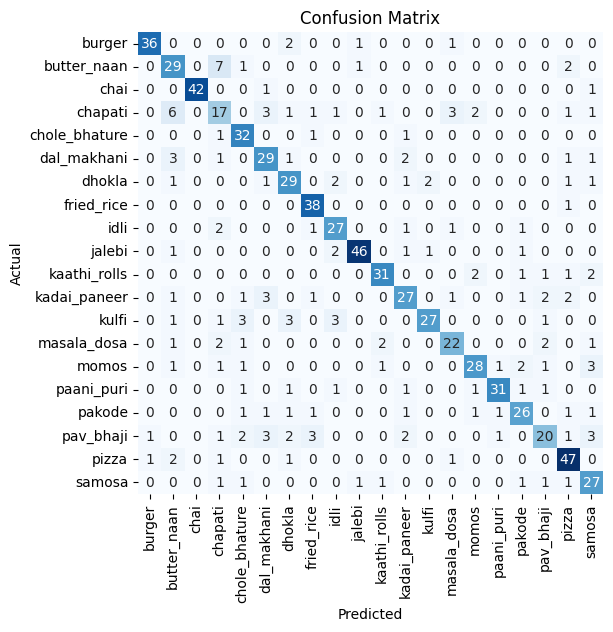

In [15]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(20) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       0.95      0.90      0.92        40
  butter_naan       0.63      0.72      0.67        40
         chai       1.00      0.95      0.98        44
      chapati       0.49      0.46      0.47        37
chole_bhature       0.73      0.91      0.81        35
  dal_makhani       0.71      0.76      0.73        38
       dhokla       0.71      0.76      0.73        38
   fried_rice       0.83      0.97      0.89        39
         idli       0.75      0.82      0.78        33
       jalebi       0.94      0.88      0.91        52
 kaathi_rolls       0.86      0.82      0.84        38
 kadai_paneer       0.73      0.69      0.71        39
        kulfi       0.90      0.69      0.78        39
  masala_dosa       0.76      0.71      0.73        31
        momos       0.82      0.72      0.77        39
   paani_puri       0.91      0.82      0.86        38
       pakode    